# Assignment 10

### 1.复习上课内容

### 2. 回答一下理论题目

#### 1. What is independent assumption in Naive bayes ?

    即所有的特征在数据集中的作用是独立同分布的

#### 2. What is MAP(maximum a posterior) and ML(maximum likelihood) ?

    MAP：极大后验法，一种计数估计，在计数之前给定一些数值（即先验概率）。先验有强弱之分，强的先验不容易受到似然估计的影响，弱的先验容易受到似然估计的影响。
    ML：极大似然估计，对于一组可以观察到的数据x，每个数据有N个维度，选择其中一个, 假设是i, 进行计数. 该数在第i维度下, 各个数字的数量. 通过以上步骤可以得出该组数据的概率分布，取概率分布密度最大的值。

#### 3. What is support vector in SVM?

    对一堆数据点进行分类时，当超平面离数据点的间隔越大，分类的确信度也越大，为了使分类的确信度尽量高，需要让所选择的超平面能够最大化这个间隔值。而在这个间隔值上的数据点被称为是支持向量(support vector)的,这就是支持向量机的由来

#### 4. What is the intuition behind SVM ?

    SVM实际上是一种二类分类模型，一种在特征空间上的间隔最大的线性分类器，其学习策略是最大化间隔，最终转化为一个凸二次规划问题的求解
    除了进行线性分类，支持向量机可以使用核函数将输入隐含映射成高维特征空间中有效地进行非线性分类。
    假设给定一组数据点，它们分别属于两个不同的类，现在要找到一个线性分类器把这些数据分成两类。如果用x表示数据点，用y表示类别，线性分类器的学习目标是要在n维的数据空间中找到一个可以将数据划分为两类的超平面，其方程可以表示为: wTx + b = 0

#### 5. Shortly describ what 'random' means in random forest ?

随机森林是一个包含多棵决策树的分类器，并且其输出的类别是由个别树输出的类别的总数而定。
随机森林的随机性体现在每颗树的训练样本是随机的，树中每个节点的分裂属性集合也是随机选择确定的。有了这2个随机的保证，随机森林就不会产生过拟合的现象了。


#### 6. What cariterion does XGBoost use to find the best split point in a tree ?

根据特征对样本数据进行排序，然后将特征从小到大进行切分，比较每次切分后的目标函数大小，选择下降最大的节点作为该特征的最优切分点。最后比较不同块结构最优切分点的目标函数下降值，选择下降最大的特征作为最优切分点。

##### Problem description: In this part you are going to build a classifier to detect if a piece of news is published by the Xinhua news agency (新华社）.

### 3. Practial part

#### Hints:

###### 1. Firstly, you have to come up with a way to represent the news. (Vectorize the sentence, you can find different ways to do so online)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import jieba
import torch
import torch.nn as nn
import torch.utils.data as Data 
from torch.autograd import Variable
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
df = pd.read_csv(r"xinhuashe.csv",encoding = 'gb18030').fillna(" ")

In [2]:
def filter_func(sen):
    sen = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*{}()（）：]+", "", sen)  
    return(sen)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)

def sentence2vec(sen, diction):
    vector = np.zeros(len(diction))
    for w in sen:
        vector[w] += 1
    return(1.0 * vector / len(sen))

def prepare_data(x_data, y_data, is_filter = True):
    all_words = []
    sentences = []
    target = []
    for __, row in x_data.iterrows():
        line = row["author"] + row["content"] + row["feature"] + row["title"] + row["url"]
        if is_filter:
            line = filter_func(line)
        words = jieba.lcut(line)
        if len(words) > 0:
            all_words += words
            sentences.append(words)

    for twords in y_data:
        if is_filter:
            twords = filter_func(twords)
        words = jieba.lcut(twords)
        if len(words) > 0:
            all_words += words
            target.append(words)
        else:
            target.append(" ")
            
    count = len(all_words)
    diction = {" ":[0, 1]}
    cnt = Counter(all_words)
    for word, freq in cnt.items():
        diction[word] = [len(diction)+1, freq]
    print('字典大小：{}'.format(len(diction)))
    return sentences,target, diction

In [3]:
y_data = df.source.values
x_data = df.drop(['source','id'], axis = 1)
sentences,target,diction  =  prepare_data(x_data, y_data)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.833 seconds.
Prefix dict has been built successfully.


字典大小：605435


In [4]:
print("sentences: ",len(sentences),"\ntarget: ", len(target), "\ndiction: ", len(diction))
print(diction["6"])
print(diction["未"])

sentences:  89611 
target:  89611 
diction:  605435
[5, 54009]
[1420, 3520]


In [5]:
def sen2vec(sentences,diction):
    new_sens = []
    for line in sentences:
        new_sen = []
        for word in line:
            new_sen.append(word2index(word,diction))
        new_sens.append(new_sen)
    return new_sens

In [6]:
senvec = sen2vec(sentences, diction)
targetvec = []
for words in target:
    if "新华社" in words:
        targetvec.append(1.0)
    else:
        targetvec.append(0.0)
        
maxLen = max(len(i) for i in senvec)
trainvec = list(map(lambda x : x + [0]*(maxLen - len(x)),senvec))

In [7]:
trainvec = torch.tensor(trainvec)
targetvec = torch.tensor(targetvec)
x_train, x_test, y_train, y_test = train_test_split(trainvec,targetvec,test_size=0.2, random_state=0)

x_train = x_train
y_train = y_train
x_test = x_test
y_test = y_test

In [8]:
print(trainvec.shape)
print(targetvec.shape)

torch.Size([89611, 7949])
torch.Size([89611])


In [9]:
torch.manual_seed(1)

batch_size = 64
learning_rate = 0.0005
num_epoches = 10

torch_dataset = Data.TensorDataset(x_train, y_train) 
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

In [10]:
print("len of x_train:",len(x_train)," Type of x train: ",type(x_train))
print("len of x_test:",len(x_test))
print("len of y_train:",len(y_train))
print("len of y_test:",len(y_test))
print("maxlen of x_train", maxLen)
print(len(trainvec[2]))
print(type(x_test))

len of x_train: 71688  Type of x train:  <class 'torch.Tensor'>
len of x_test: 17923
len of y_train: 71688
len of y_test: 17923
maxlen of x_train 7949
7949
<class 'torch.Tensor'>


###### 2. Secondly,  pick a machine learning algorithm that you think is suitable for this task

In [11]:
class BatchFCN(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(BatchFCN,self).__init__()
        self.lr1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1), nn.ReLU(True))
        self.lr2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2), nn.ReLU(True))
        self.lr3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        self.acf = nn.Sigmoid()
        
    def forward(self, x):
        x = self.lr1(x)
        x = self.lr2(x)
        x = self.lr3(x)
        x = self.acf(x)
        return x

batchModel = BatchFCN(7949,400,20,1)
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(batchModel.parameters(), lr=learning_rate, momentum=0.9)

In [12]:
epoch = 0
Totalloss = []
for epoch in range(num_epoches):
    for step, (batch_x, batch_y) in enumerate(loader):
        out = batchModel(batch_x.float())
        #print(out[1],batch_y[1])
        loss = criterion(out, batch_y)
        print_loss = loss.data.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step%100 == 0:
            Totalloss.append(print_loss)
        if step%500 == 0:
            print('epoch: {},step:{} loss: {:.4}'.format(epoch,step,print_loss))

/home/anaconda3/envs/pth/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch: 0,step:0 loss: 0.5643
epoch: 0,step:500 loss: 0.1511
epoch: 0,step:1000 loss: 0.1929


/home/anaconda3/envs/pth/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


epoch: 1,step:0 loss: 0.1115
epoch: 1,step:500 loss: 0.05854
epoch: 1,step:1000 loss: 0.02902
epoch: 2,step:0 loss: 0.02545
epoch: 2,step:500 loss: 0.05332
epoch: 2,step:1000 loss: 0.02644
epoch: 3,step:0 loss: 0.0171
epoch: 3,step:500 loss: 0.03385
epoch: 3,step:1000 loss: 0.06215
epoch: 4,step:0 loss: 0.01672
epoch: 4,step:500 loss: 0.02586
epoch: 4,step:1000 loss: 0.03182
epoch: 5,step:0 loss: 0.03198
epoch: 5,step:500 loss: 0.009436
epoch: 5,step:1000 loss: 0.01387
epoch: 6,step:0 loss: 0.08995
epoch: 6,step:500 loss: 0.01368
epoch: 6,step:1000 loss: 0.006683
epoch: 7,step:0 loss: 0.009645
epoch: 7,step:500 loss: 0.006766
epoch: 7,step:1000 loss: 0.009588
epoch: 8,step:0 loss: 0.03084
epoch: 8,step:500 loss: 0.00717
epoch: 8,step:1000 loss: 0.07444
epoch: 9,step:0 loss: 0.006117
epoch: 9,step:500 loss: 0.004176
epoch: 9,step:1000 loss: 0.006453


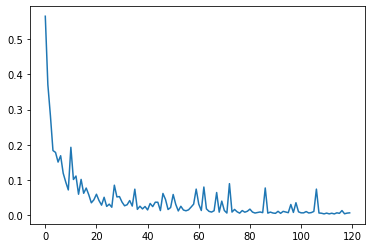

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(Totalloss)), Totalloss)

In [14]:
test_data = Data.TensorDataset(x_test, y_test) 
test_loader = Data.DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2,
)
# 模型评估
batchModel.eval()
eval_loss = 0
for test_x, test_y in test_loader: 
    out = batchModel(test_x.float())
    loss = criterion(out, test_y)
    eval_loss += loss.data.item()*test_y.size(0)

print('Test Loss: {:.6f}'.format(eval_loss / (len(test_data)) ))

/home/anaconda3/envs/pth/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Test Loss: 0.028205


/home/anaconda3/envs/pth/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


### Congratulations! You have completed all assignments in this week. The question below is optional. If you still have time, why don't try it out.

## Option:

#### Try differnt machine learning algorithms with different combinations of parameters in the practical part, and compare their performances (Better use some visualization techiniques).